# Image filtering, using pixel neighbors

So far, we have used only pixel values to process images. However, we can do more advanced image processing using spatial information about pixels and their neighbors. Indeed, in natural images neighboring pixels tend to have similar intensities, to belong to the same object, etc.

Here we will see:

- how to filter images, i.e. how to modify pixel values according to neighboring values (e.g. for denoising, edge detection, or image cleaning).

- how to segment an object, i.e. how to attribute labels to pixels, corresponding to different objects.

![plot label](plot_label.png)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This code is only for visualization, you don't have to look at it.

from skimage import img_as_float

def imshow_all(*images, **kwargs):
    """ Plot a series of images side-by-side.

    Convert all images to float so that images have a common intensity
    range.

    Parameters
    ----------
    limits : str
        Control the intensity limits. By default, 'image' is used set the
        min/max intensities to the min/max of all images. Setting `limits` to
        'dtype' can also be used if you want to preserve the image exposure.
    titles : list of str
        Titles for subplots. If the length of titles is less than the number
        of images, empty strings are appended.
    kwargs : dict 
        Additional keyword-arguments passed to `imshow`.
    """
    images = [img_as_float(img) for img in images]

    titles = kwargs.pop('titles', [])
    if len(titles) != len(images):
        titles = list(titles) + [''] * (len(images) - len(titles))

    limits = kwargs.pop('limits', 'image')
    if limits == 'image':
        kwargs.setdefault('vmin', min(img.min() for img in images))
        kwargs.setdefault('vmax', max(img.max() for img in images))
    elif limits == 'dtype':
        vmin, vmax = dtype_limits(images[0])
        kwargs.setdefault('vmin', vmin)
        kwargs.setdefault('vmax', vmax)

    nrows, ncols = kwargs.get('shape', (1, len(images)))

    size = nrows * kwargs.pop('size', 5)
    width = size * len(images)
    if nrows > 1:
        width /= nrows * 1.33
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, size))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, **kwargs)
        ax.set_title(label)


## Image filtering

Linear filters are a convolution between an image and a local kernel, which mixes together pixel values in a neighbourhood of the central pixel. The local kernel can take different values, and also have different supports (square, diamond, disk...).

![Local kernels](kernels.png)


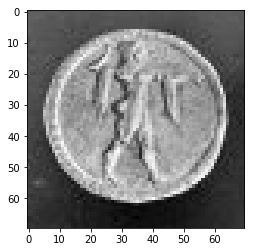

In [3]:
from skimage import data, filters
coins = data.coins()
coins_zoom = coins[10:80, 300:370]
plt.imshow(coins_zoom, cmap='gray')

Here we show how to use two different denoising filters:

- the **gaussian kernel** (a square kernel with Gaussian weights) smoothes out noise, but also image features (such as edges)

- the **median filter** replaces a pixel by the median value in a neighbourhood. It also decreases noise, but is better at keeping sharp edges.

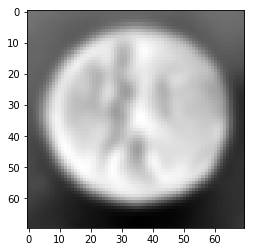

In [4]:
gaussian_coins = filters.gaussian(coins_zoom, 2)
plt.imshow(gaussian_coins, cmap='gray')

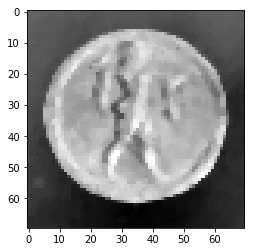

In [5]:
median_coins = filters.rank.median(coins_zoom, np.ones((3, 3)))
plt.imshow(median_coins, cmap='gray')

<div class="alert alert-success">
    <b>EXERCISE</b>: Visualize and print the weights of the Gaussian kernel (for sigma=1), using an image with a single non-zero pixel (a "delta-function" in mathematical terms).
</div>

![delta gaussian](delta_gaussian.png)

[[ 0.00291504  0.01306431  0.02153941  0.01306431  0.00291504]
 [ 0.01306431  0.05855018  0.09653293  0.05855018  0.01306431]
 [ 0.02153941  0.09653293  0.15915589  0.09653293  0.02153941]
 [ 0.01306431  0.05855018  0.09653293  0.05855018  0.01306431]
 [ 0.00291504  0.01306431  0.02153941  0.01306431  0.00291504]]


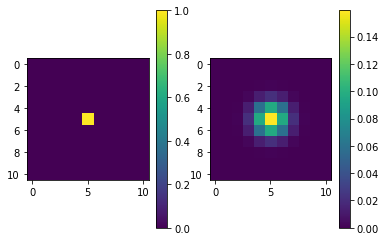

In [6]:
# Your solution goes here
a = np.zeros((11, 11))
a[5, 5] = 1
gaussian_a = filters.gaussian(a, 1)
print(gaussian_a[3:-3, 3:-3])
fig, axes = plt.subplots(ncols=2)
im0 = axes[0].imshow(a)
im1 = axes[1].imshow(gaussian_a)
fig.colorbar(im0, ax=axes[0])
fig.colorbar(im1, ax=axes[1])

## Mathematical morphology

Morphology is the study of shapes. In image processing, some simple operations can get you a long way. The first things to learn are *erosion* and *dilation*. In erosion, we look at a pixel’s local neighborhood and replace the value of that pixel with the minimum value of that neighborhood. In dilation, we instead choose the maximum.

In [7]:
plt.rcParams['image.cmap'] = 'cubehelix'

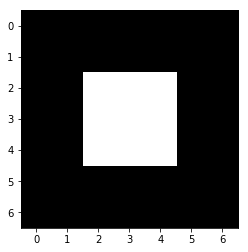

In [8]:
image = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 0, 0],
                  [0, 0, 1, 1, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0]], dtype=np.uint8)
plt.imshow(image);

The documentation for scikit-image's morphology module is
[here](http://scikit-image.org/docs/0.10.x/api/skimage.morphology.html).

Importantly, we must use a *structuring element*, which defines the local
neighborhood of each pixel. To get every neighbor (up, down, left, right, and
diagonals), use `morphology.square`; to avoid diagonals, use
`morphology.diamond`:

In [9]:
from skimage import morphology
sq = morphology.square(width=3)
dia = morphology.diamond(radius=1)
print("square:\n", sq)
print("diamond:\n", dia)

square:
 [[1 1 1]
 [1 1 1]
 [1 1 1]]
diamond:
 [[0 1 0]
 [1 1 1]
 [0 1 0]]


The central value of the structuring element represents the pixel being considered, and the surrounding values are the neighbors: a 1 value means that pixel counts as a neighbor, while a 0 value does not. So:

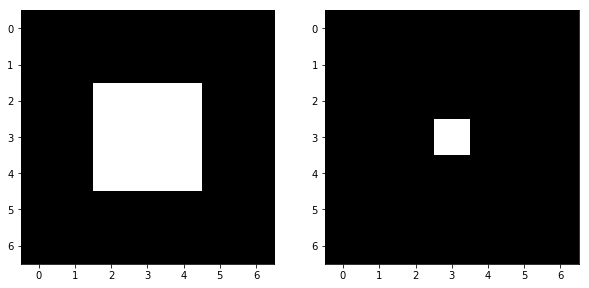

In [10]:
eroded = morphology.erosion(image, dia)
imshow_all(image, eroded, shape=(1, 2))

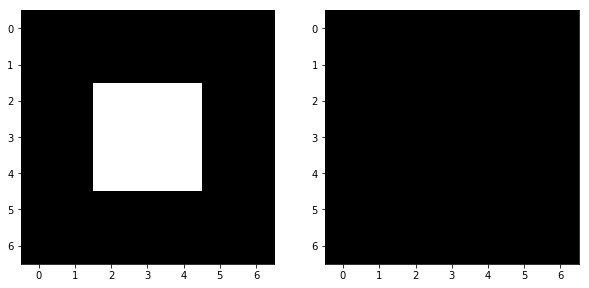

In [11]:
eroded_too_much = morphology.erosion(image, morphology.square(5))
imshow_all(image, eroded_too_much, shape=(1, 2))

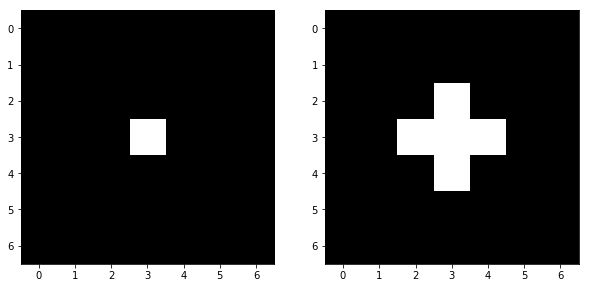

In [12]:
dil_dia = morphology.dilation(eroded, dia)
imshow_all(eroded, dil_dia, shape=(1, 2))

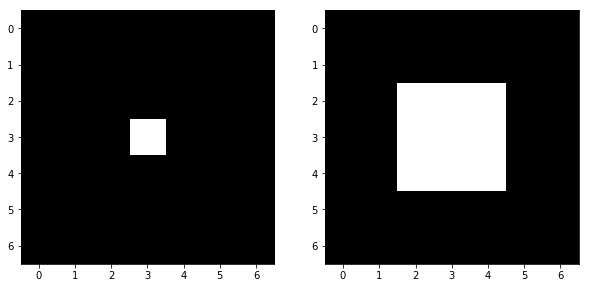

In [13]:
dil_sq = morphology.dilation(eroded, sq)
imshow_all(eroded, dil_sq, shape=(1, 2))

<div class="alert alert-success">
    <b>EXERCISE</b>: clean a noisy image.
    
Below we create a binary image with large blobs, but also some random noise (that could have generated from thresholding a noisy image, for example). Let's try to clean it without altering too much the shape of the blobs, using mathematical morphology.
    
To remove small 0-valued (black) objects, you can use a combination of dilation followed by erosion, called closing (``skimage.morphology.binary_closing``). To remove small 1-valued (white) objects, you can use the reverse combination: erosion followed by dilation, called opening.
</div>


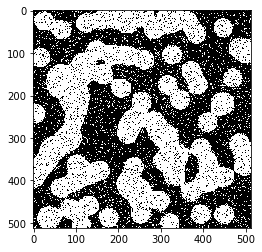

In [14]:
im = data.binary_blobs() - 0.5
im += 0.4 * np.random.randn(*im.shape)
noisy_im = im > 0
plt.imshow(noisy_im)

(-0.5, 511.5, 511.5, -0.5)

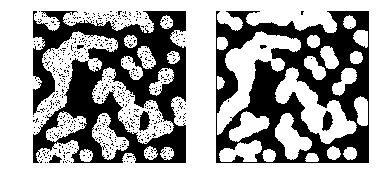

In [15]:
# Your solution goes here
dia = morphology.diamond(radius=2)
opening = morphology.binary_opening(noisy_im)
closing = morphology.binary_closing(opening, dia)
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(opening)
axes[0].axis('off')
axes[1].imshow(closing)
axes[1].axis('off')

## Image segmentation

Image segmentation consists in attributing labels to pixels, corresponding to objects of interest (for example, object and background). We have already seen several segmentation strategies:

- simple thresholding
- thresholding with pre-processing (such as image denoising, e.g. with a median filter) or post-pocessing(e.g. cleaning a binary image with mathematical morphology).

More advanced algorithms are possible and require less hand-tuning of pre- or post-processing. However, they all require user-supplied information. Even machine-learning (e.g. deep learning) algorithms, which detect objects automatically, have used huge training sets for this.

In [16]:
plt.rcParams['image.cmap'] = 'viridis'

### Marker-based segmentation

Let's start with the **marker-based** approach. Remember this coins image with an uneven illumination? Simple thresholding did not work well, but fortunately we can use the tails of the histogram: the brightest pixels do correspond to coins, and the darkest to the background. Therefore, we will be able to use these pixel as **markers**, which will **propagate their label** to neighboring pixels.

107


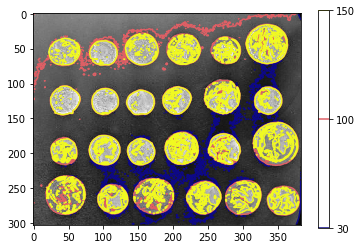

In [17]:
coins = data.coins()
plt.imshow(coins, cmap='gray')
print(filters.threshold_otsu(coins))
cs = plt.contour(coins, [30, 100, 150], cmap='plasma')
plt.colorbar(cs)

(-0.5, 383.5, 302.5, -0.5)

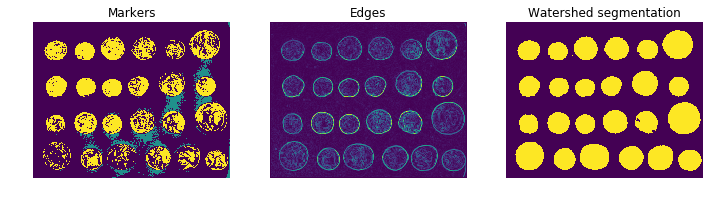

In [18]:
edges = filters.sobel(coins)
markers = np.zeros_like(coins)
background, foreground = 1, 2
markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

from skimage import segmentation
ws = segmentation.watershed(edges, markers)

# Figure
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(markers)
plt.title('Markers')
plt.axis('off')
plt.subplot(132)
plt.imshow(edges)
plt.title('Edges')
plt.axis('off')
plt.subplot(133)
plt.imshow(ws)
plt.title('Watershed segmentation')
plt.axis('off')

<div class="alert alert-info">
    
**Going further**: for the marker-based strategy, also consider using the [random walker algorithm](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_random_walker_segmentation.html), which is more robust to noise (but is slower and requires more memory than the watershed).

</div>




### Merging-based segmentation

Instead of choosing known markers (e.g. using the histogram), it is also possible to make an over-segmentation using seeds, which can be placed at random or on a regular grid. Each seed will propagate to neighboring pixels with similar gray levels.

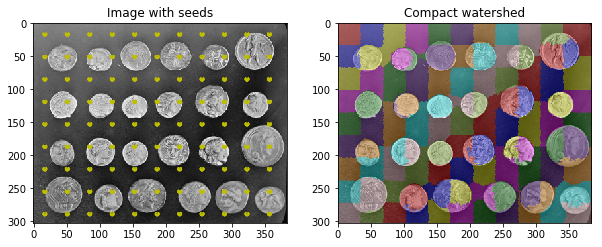

In [19]:
from skimage import util, color
grid = util.regular_grid(coins.shape, n_points=100)

seeds = np.zeros(coins.shape, dtype=int)
seeds[grid] = np.arange(seeds[grid].size).reshape(seeds[grid].shape) + 1

ws_seeds = segmentation.watershed(edges, seeds, compactness=0.01)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ax0.imshow(coins, cmap='gray')
ax0.contour(seeds > 0, colors='y', linewidths=4)
ax0.set_title('Image with seeds')

ax1.imshow(color.label2rgb(ws_seeds, coins))
ax1.set_title('Compact watershed')


A post-processing step is needed to merge together regions belonging to the same object. This is not covered here, but you can read [this example](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_rag_mean_color.html) or [this other example](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_boundary_merge.html)  to know more about region merging.

**See also**: more [segmentation examples](http://scikit-image.org/docs/stable/auto_examples/#segmentation-of-objects) in scikit-image gallery.

## Labeling objects and measuring their properties

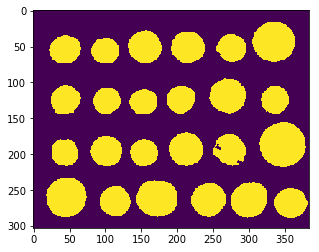

In [20]:
plt.imshow(ws)

number of coins: 27


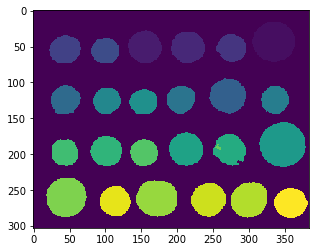

In [21]:
from skimage import measure
labels = measure.label(ws)
plt.imshow(labels)
print("number of coins:", labels.max())

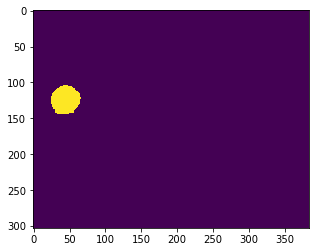

In [22]:
plt.imshow(labels == 10)

In [23]:
properties = measure.regionprops(labels, coins)
print(properties)
print(dir(properties[0]))

[<skimage.measure._regionprops._RegionProperties object at 0x7f8b480d9358>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d9438>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d9080>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d90b8>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d9278>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d7ac8>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d7b00>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d7b38>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d7be0>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d7908>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d7940>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d7a20>, <skimage.measure._regionprops._RegionProperties object at 0x7f8b480d7780>, <skimage.measure._region

In [24]:
areas = [prop.area for prop in properties]
print("areas:", areas)
mean_intensities = [prop.mean_intensity for prop in properties]
print("mean intensities:", mean_intensities)

areas: [77407, 2604, 1653, 1622, 1225, 1355, 1103, 2, 1920, 1298, 1209, 1175, 1111, 1077, 3141, 1737, 1461, 1471, 1124, 1152, 35, 2461, 2350, 1993, 1765, 1416, 1485]
mean intensities: [65.541398064774498, 156.8083717357911, 169.37084089534181, 157.60727496917386, 154.20326530612246, 167.82140221402213, 184.31822302810517, 167.0, 158.61458333333334, 190.66409861325116, 171.95947063688999, 170.1863829787234, 191.13681368136812, 194.68337975858867, 149.72556510665393, 159.18998272884284, 161.91170431211498, 173.08225696804894, 154.15480427046262, 177.2109375, 106.59999999999999, 131.01503453880537, 130.98851063829787, 144.9839438033116, 152.03002832861191, 152.13135593220338, 153.61616161616161]


## Mid-level features 

So far we have seen

- how to modify pixel values using a very local neighbourhood 

- how to segment a whole image into labeled regions.

For some applications it is also interesting to detect mid-level features, such as edges, corner, high gradients, etc. Such features can be used for image classification of for image registration.

Here we only briefly show two examples: edge detection with Canny filter, and corner detection with Harris

### Edge detection with Canny filter

The Canny filter performs a hysteresis thresholding on the norm of the gradient (Sobel filter). Therefore, it tends to produce connected edges, with less noise than just thresholding the output of the Sobel filter.

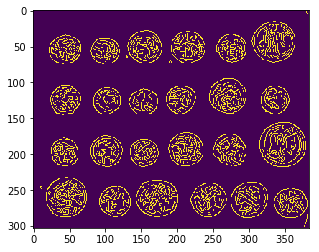

In [25]:
from skimage import feature
canny = feature.canny(coins)
plt.imshow(canny)

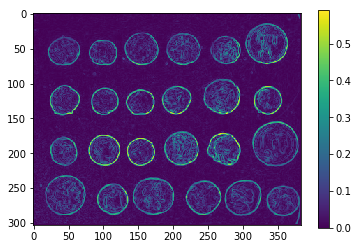

In [26]:
sobel = filters.sobel(coins)
plt.imshow(sobel)
plt.colorbar()

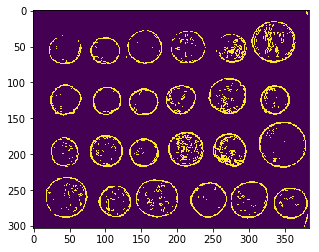

In [27]:
plt.imshow(sobel > 0.15)

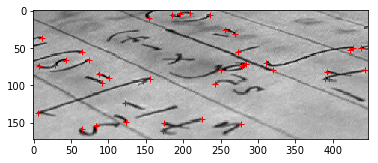

In [28]:
text = data.text()
coords= feature.corner_peaks(feature.corner_harris(text), 
                             min_distance=3)
plt.imshow(text, cmap='gray')
plt.plot(coords[:, 1], coords[:, 0], '+r')

See http://scikit-image.org/docs/dev/auto_examples/#detection-of-features-and-objects for more examples of feature detection.